In [1]:
import cv2
import json
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import re
import random
from PIL import Image
import transformers as T
import math
from utils import *
from models import *

/Users/saptarshimallikthakur/Desktop/google_lens/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the dictionary from the file
with open('Cloth Description.json', 'r') as file:
    cloth_description = json.load(file)

# Pruning Dataset

1. Due to computational and time constraint i will be building a recommnedation system for only **Upper Garments**.
2. For an image i will detect the clothing whether 'Upper Garment' is present or not.
3. If present i will query the description from cloth_description dict and save it along with cropped image.

In [ ]:
# Dictionary to store descriptions for upper garments
upper_garment_description = {}

# Ensure the folder 'upper' exists
folder_name = "upper_garment_images"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Iterate through the image keys
img_keys = list(cloth_description.keys())

for img_key in img_keys:
    if 'upper' in cloth_description[img_key].keys():  # Check if the current image has an 'upper' category in the cloth description
        detection = detect_clothing(img_key, model_yolo, labels, upper, lower)

        # Extract the cropped image
        cropped_image = detection[0]['cropped_image']  # Ensure this key exists and contains a valid image
        if cropped_image is not None:  # Check if the cropped image is valid
            # Convert BGR to RGB
            cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

            # Extract the base filename from the image key
            base_filename = os.path.basename(img_key)  # e.g., 'image_100.jpg'
            new_filename = f"upper_{base_filename}"   # e.g., 'upper_image_100.jpg'

            # Define the save path
            save_path = os.path.join(folder_name, new_filename)

            # Save the RGB image
            cv2.imwrite(save_path, cropped_image_rgb)

            upper_garment_description[save_path] = cloth_description[img_key]['upper']
            print(f"Saved: {save_path}")


# Save the dictionary to a file
with open("upper_garment_description.json", 'w') as file:
    json.dump(upper_garment_description, file)

In [4]:
# # Load the dictionary from the file
# with open('upper_garment_description.json', 'r') as file:
#     upper_garment_description = json.load(file)

df = pd.DataFrame(list(upper_garment_description.items()), columns=["image_path", "caption"])
df

,image_path,caption
0,upper_garment_images/upper_image_100.jpg,"The image showcases a cozy, oversized cardigan..."
1,upper_garment_images/upper_image_1000.jpg,"The image features a light blue, long-sleeved ..."
2,upper_garment_images/upper_image_10001.jpg,The garment in the image is a woman's mini dre...
3,upper_garment_images/upper_image_10002.jpg,The garment in the image is a women's halter-n...
4,upper_garment_images/upper_image_10003.jpg,"The image depicts a person wearing a casual, u..."
...,...,...
2867,upper_garment_images/upper_image_3087.jpg,The image depicts a young person wearing a cla...
2868,upper_garment_images/upper_image_3088.jpg,The clothing item visible is a classic denim j...
2869,upper_garment_images/upper_image_3089.jpg,"This image showcases a form-fitting, knee-leng..."
2870,upper_garment_images/upper_image_3090.jpg,The image showcases a sleeveless women's midi ...


# CLIP 

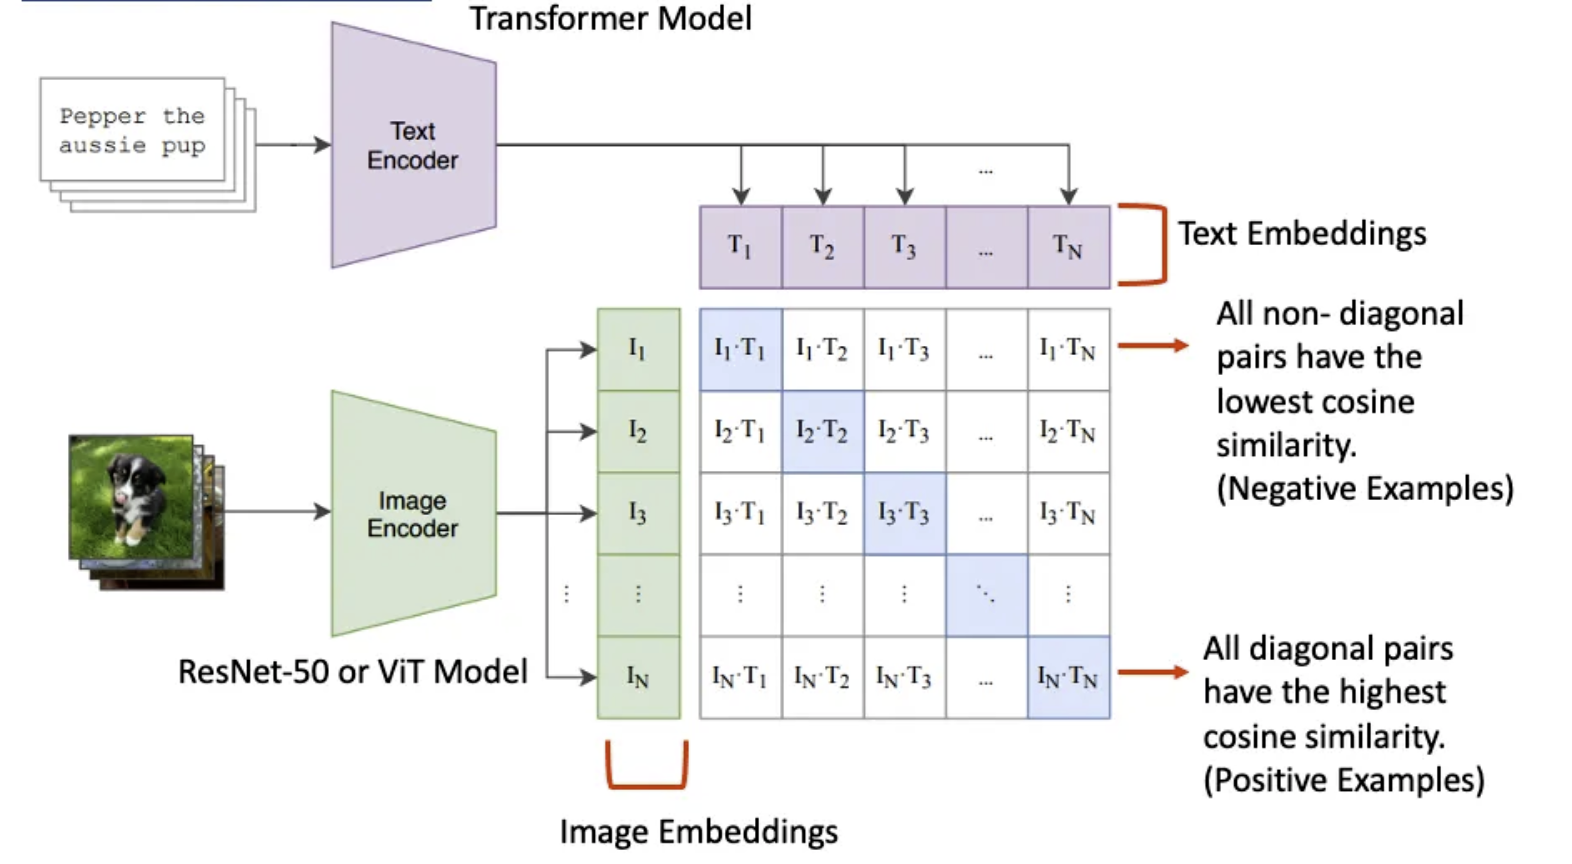

CLIP model learns a multi-modal embedding space by jointly training its encoders to maximize the cosine similarity of the image and text embeddings of the N real pairs in the batch while minimising the cosine similarity of the embeddings of the N² − N incorrect pairings.

In [5]:
def create_train_test_dl(df: pd.DataFrame, test_size: float=0.2) -> Tuple[DataLoader]:

  ids = list(range(df.shape[0]))
  test_ids = random.sample(ids, k=int(df.shape[0]*test_size))
  train_ids = [i for i in ids if i not in test_ids]

  train_df = df.iloc[train_ids, :].copy(deep=True)
  test_df = df.iloc[test_ids, :].copy(deep=True)

  train_df = train_df.reset_index(drop=True)
  test_df = test_df.reset_index(drop=True)

  train_ds, test_ds = CLIPDataset(df=train_df), CLIPDataset(df=test_df)
  train_dl = DataLoader(dataset=train_ds,
                        batch_size=4,
                        shuffle=True)
  test_dl = DataLoader(dataset=test_ds,
                       batch_size=4,
                       shuffle=False)
  return train_dl, test_dl

In [6]:
device = "mps"

train_dl, test_dl = create_train_test_dl(df=df)

clip = CLIP().to(device)

optimizer = torch.optim.AdamW(params=clip.parameters(), lr=1e-4)


def train_step() -> float:

  clip.train()
  total_loss = 0

  for batch in train_dl:
    image, token, attention_mask = batch['image'], batch['input_ids'], batch['attention_mask']
    image, token, attention_mask = image.to(device), token.to(device), attention_mask.to(device)

    _, loss = clip(image, token, attention_mask)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(train_dl)

@torch.inference_mode()
def eval_step() -> float:

  clip.eval()
  total_loss = 0

  for batch in test_dl:

    image, token, attention_mask = batch['image'], batch['input_ids'], batch['attention_mask']
    image, token, attention_mask = image.to(device), token.to(device), attention_mask.to(device)

    _, loss = clip(image, token, attention_mask)

    total_loss += loss.item()

  return total_loss/len(test_dl)

In [ ]:
import gc

def main(epochs: int=2):

  for epoch in range(1, epochs+1):
    train_loss = train_step()
    test_loss = eval_step()

    print(f"({epoch}/{epochs}) train: {train_loss:.4f} test: {test_loss:.4f}")
    
    gc.collect()
    if torch.has_mps:
        torch.mps.empty_cache()  # For MPS


main(7)

In [21]:
torch.save(clip.state_dict(), "clip.pt")

In [27]:
@torch.inference_mode()
def create_image_embeddings(model, df: pd.DataFrame) -> torch.Tensor:

  model.eval()

  ds = CLIPDataset(df=df)
  dl = DataLoader(dataset=ds, batch_size=64, shuffle=False)

  image_embeddings = []
  for batch in dl:
    image = batch['image']
    image = image.to(device)

    embeddings = model.image_projection(clip.image_encoder(image)) # B, projection_dim
    image_embeddings.append(embeddings)

  return torch.cat(image_embeddings, dim=0)

image_embeddings = create_image_embeddings(clip,df=df)
image_embeddings.shape

/var/folders/17/w3818qh1047crr4wkhgmjkvh0000gn/T/ipykernel_23177/122280031.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output["input_ids"] = torch.tensor(self.caption_tokenized["input_ids"][idx])
/var/folders/17/w3818qh1047crr4wkhgmjkvh0000gn/T/ipykernel_23177/122280031.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output["attention_mask"] = torch.tensor(self.caption_tokenized["attention_mask"][idx])


torch.Size([2872, 256])

In [ ]:
# Save the tensor to a file
torch.save(image_embeddings, "image_embeddings.pt")